## Vehicle Detection and Tracking Project

**The goals / steps of this project are the following:**

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
Note: for those first two steps ,also have to normalize features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

#### Import modules

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import os
import helper_functions
import pickle
from scipy.ndimage.measurements import label
import helpers
% matplotlib inline

#### Load data for training and test

In [4]:
cars=glob.glob('vehicles/**/*.png')
notcars = glob.glob('non-vehicles/**/*.png')
print('There are {} car images, {} notcar images.'.format(len(cars), len(notcars)))

There are 8792 car images, 8968 notcar images.


#### Set parameters

In [12]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
svc = LinearSVC()

#### Train classifer
Train functions details can be found at `helper_functions.py` at the root folder.

In [4]:
#Train classifier
helper_functions.train(cars,notcars,color_space,spatial_size,hist_bins,orient,pix_per_cell,cell_per_block,hog_channel,spatial_feat,hist_feat,hog_feat,svc)

Start extract features...
237.72 Seconds to extract features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
26.92 Seconds to train SVC...
Test Accuracy of SVC =  0.9876


#### Define Lane line detection pipeline

In [13]:
#Lane lines detect pipeline
def lane_pipeline(image):
    undistorted = helpers.cal_undistort(image) #undistored image
    combined_image = helpers.threshold(undistorted) #get binary image
    binary_warped, Minv = helpers.corners_unwarp(combined_image) #get transformed image
    left_curverad,right_curverad, dx= helpers.find_curvature(binary_warped) #get curvature
    result=helpers.vis(undistorted,binary_warped,Minv) #visulize detected lane lines result in image
    return result

#### Define car detection and tracking pipiline

In [5]:
def car_pipeline(img):
    
	dist_pickle = pickle.load( open("dist_pickle.p", "rb" ))
	svc = dist_pickle["svc"]
	X_scaler=dist_pickle['scaler']
	color_space=dist_pickle['color_space']
	orient=dist_pickle['orient']
	pix_per_cell=dist_pickle['pix_per_cell']
	cell_per_block=dist_pickle['cell_per_block']
	hog_channel=dist_pickle['hog_channel']
	spatial_size=dist_pickle['spatial_size']
	hist_bins=dist_pickle['hist_bins']
	spatial_feat=dist_pickle['spatial_feat']
	hist_feat=dist_pickle['hist_feat']
	hog_feat=dist_pickle['hog_feat']
	ystart = 400
	ystop = 656
	scale = 1.5

	box_list, image=helper_functions.find_cars(img, X_scaler, svc, ystart, ystop,color_space, scale, orient, pix_per_cell, hog_feat, hog_channel, cell_per_block, spatial_feat, spatial_size, hist_bins, hist_feat)
	heat = np.zeros_like(img[:,:,0]).astype(np.float)
	# Add heat to each box in box list
	heat = helper_functions.add_heat(heat, box_list)
	# Apply threshold to help remove false positives
	heat = helper_functions.apply_threshold(heat, 2)
	# Visualize the heatmap when displaying    
	heatmap = np.clip(heat, 0, 255)
	# Find final boxes from heatmap using label function
	labels = label(heatmap)
	draw_img = lane_pipeline(img)
	draw_img = helper_functions.draw_labeled_bboxes(draw_img, labels)
	return draw_img

## Test on images

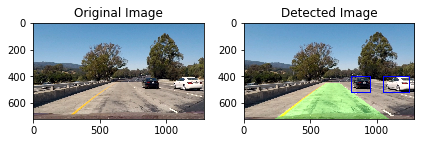

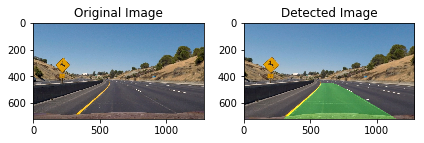

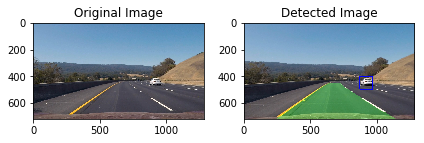

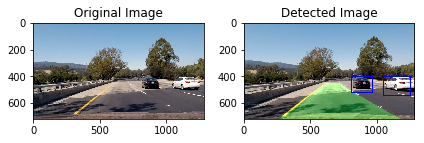

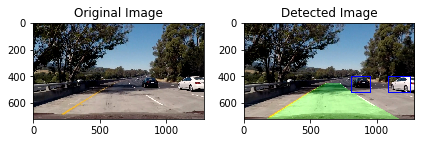

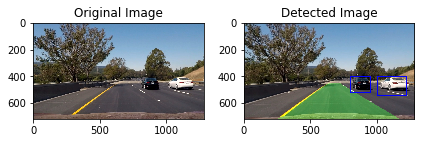

In [7]:
test_imgs = glob.glob('test_images/*.jpg')
for index, img in enumerate(test_imgs):
	img=mpimg.imread(img)
	output = car_pipeline(img)
	fig = plt.figure()
	plt.subplot(121)
	plt.imshow(img)
	plt.title('Original Image')
	plt.subplot(122)
	plt.imshow(output)
	plt.title('Detected Image')
	fig.tight_layout()
	file_name = 'output_images/test'+str(index+1)+'.jpg'
	plt.savefig(file_name)

## Test on Videos

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
white_output = 'test_videos_output/test_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_video.mp4")
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(car_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/test_video.mp4
[MoviePy] Writing video test_videos_output/test_video.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:51<00:01,  1.35s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video.mp4 

Wall time: 53.6 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [26]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(car_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [32:27<00:01,  1.55s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 32min 30s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))